# Импорты+Дата сет

Цель - предсказать траты на медицинскую страховку в зависимости от данных клиента

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import sklearn
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder,LabelEncoder,PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import confusion_matrix, roc_curve, plot_roc_curve, auc, ConfusionMatrixDisplay,roc_auc_score,r2_score,mean_squared_error,mean_absolute_error
import sklearn.datasets
import sklearn.metrics as metrics
from sklearn import preprocessing

import scipy as sp
from scipy.stats import boxcox
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering,DBSCAN

import time
import plotly.express as px
from pprint import pprint
import warnings
import pylab
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv('https://www.dropbox.com/s/lddn7qsu3kfvkvh/insurance.csv?dl=1', sep=',')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 1. **Удаление дубликатов**




In [3]:
df.shape

(1338, 7)

In [4]:
df.duplicated

<bound method DataFrame.duplicated of       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]>

Дубликаты отсутствуют

# **2. Определим переменные с пропущенными значениями и обработаем пропуски**

In [5]:
df.isnull().mean() * 100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

Как мы видим, в строках не содержатся отсутсвующие значения.

# **3.Описательная статистика. Пройфайлинг.**

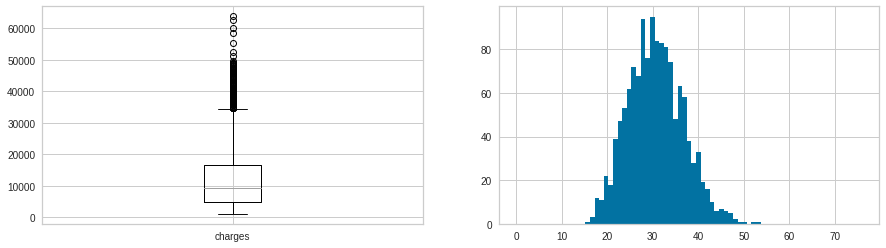

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(4)
fig.set_figwidth(15)


df.boxplot(column=['charges'], ax=ax1)
df.bmi.hist(ax=ax2, bins=75, range=(0, 76))

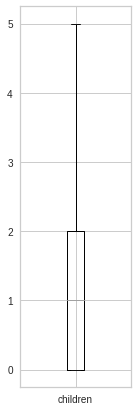

In [7]:
df.boxplot(column=['children'], figsize = (2, 7))

Профилирование данных.

In [8]:
!pip install pandas_profiling --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from pandas_profiling import ProfileReport

In [10]:
# создаём отчёт
profile = ProfileReport(df, title='test')
#Выводим отчет на экран (займет некоторое время)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

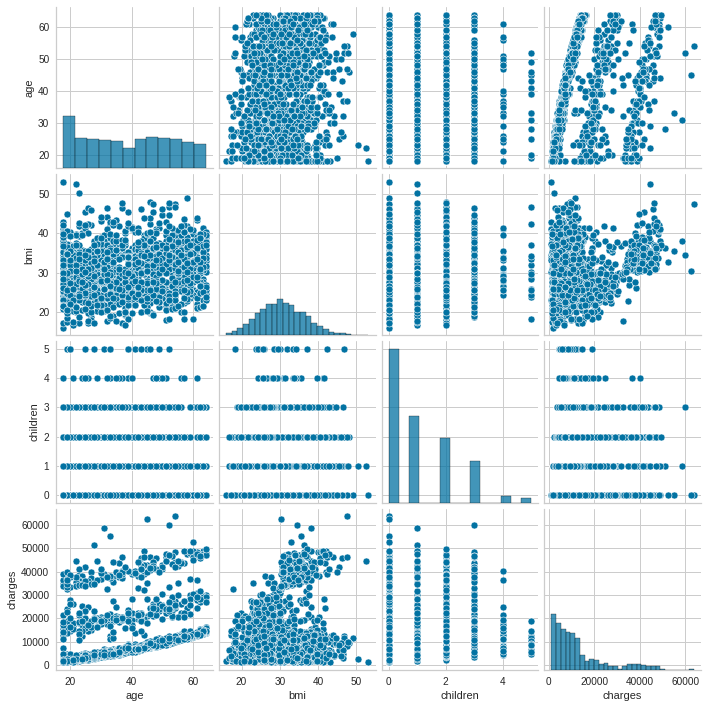

In [11]:
sn.pairplot(df)

Как мы видим по графику корреляции Спермана, есть сильная корреляция между тем, сколько человеку лет и его тратами на мед. услуги.

**Важность признаков**


In [12]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [13]:
di = {"yes": 1, 
      "no": 0,
     }
df["smoker"].replace(di, inplace=True)

# **Визуализации**

In [14]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker        int64
region       object
charges     float64
dtype: object

<BarContainer object of 1338 artists>

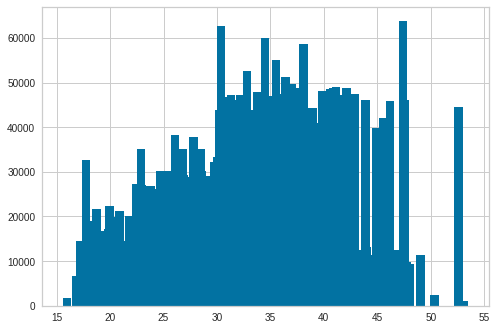

In [15]:
plt.bar(df["bmi"],df["charges"])

Как мы видим, чем выше индекс массы человека, тем больше денег он тратит на лечение.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


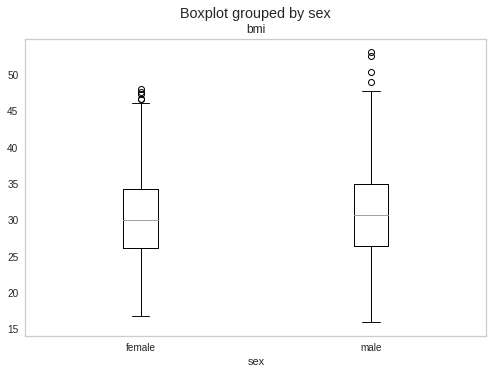

In [16]:
df.boxplot(by ='sex', column =['bmi'], grid = False)

Мужчины имеют лучший bmi.

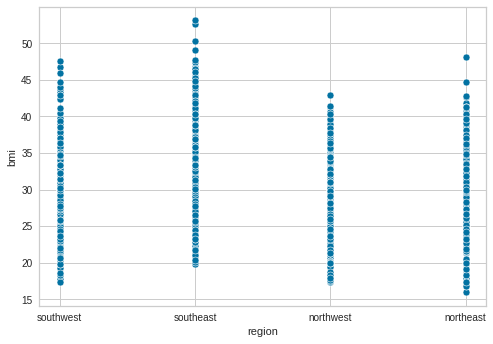

In [17]:

sn.scatterplot(data=df, x="region", y="bmi");

Самые толстые люди проживают в sputheast, а худые в nortwest.

# **FEATURE ENGINEERING**

In [18]:
X = df[['bmi', 'charges', 'age','children']]
y = df.iloc[:, -3]

In [19]:
y

0       1
1       0
2       0
3       0
4       0
       ..
1333    0
1334    0
1335    0
1336    0
1337    1
Name: smoker, Length: 1338, dtype: int64

In [20]:
bestfeatures = SelectKBest(score_func = chi2, k = 'all')
bestfeatures.fit_transform(X, y)
fit = bestfeatures.fit(X, y)

In [21]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [22]:
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(5, 'Score'))

      Specs         Score
1   charges  9.157199e+06
2       age  4.213558e+00
3  children  1.044776e-01
0       bmi  2.280730e-02


In [23]:
features = ['bmi', 'age']
x = df.loc[:, features].values

Корреляционная матрица

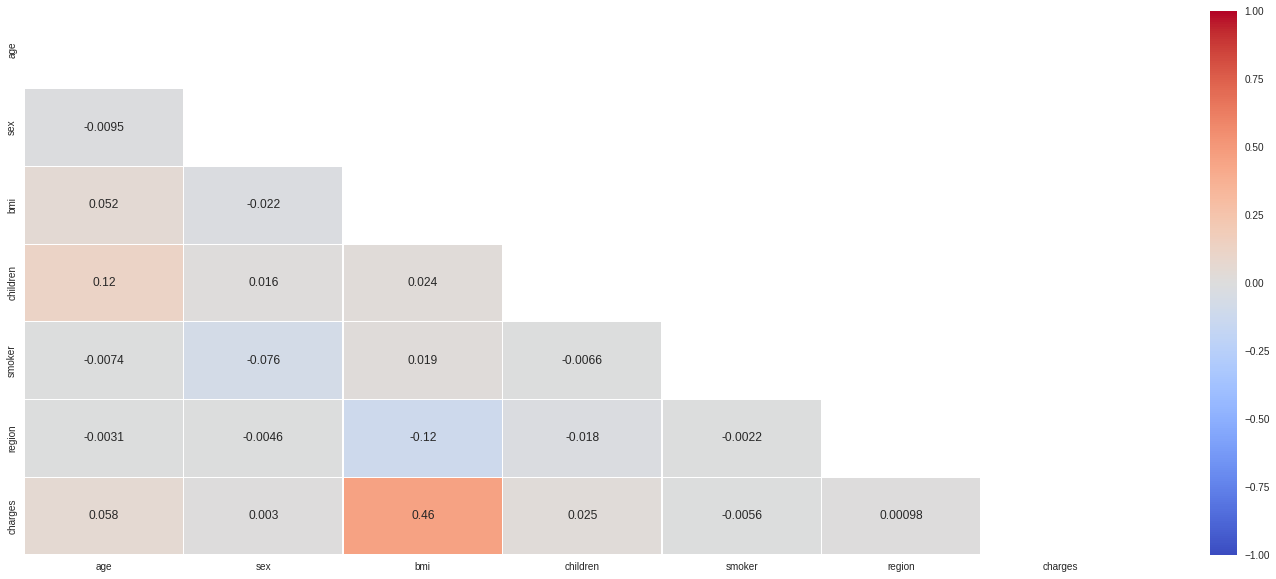

In [24]:
plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sn.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

# **ЕДА**

In [25]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520


Charges - основная колонка в этом датасете, на основе нее можно делать прогноз и Feature Engineering. Она говорит о том,сколько потратил человек на медицинские услуги.

Text(0.5, 1.0, 'Charges of age')

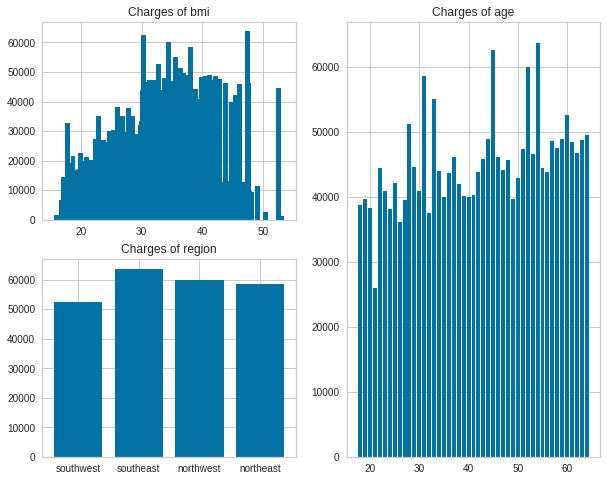

In [26]:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,8))
pylab.subplot (2, 2, 1)
plt.bar(df["bmi"],df["charges"])
pylab.title ("Charges of bmi")
pylab.subplot (2, 2, 3)
plt.bar(df["region"],df["charges"])
pylab.title ("Charges of region")
pylab.subplot (1, 2, 2)
plt.bar(df["age"],df["charges"])
pylab.title ("Charges of age")

Меньше всего тратят люди, которые имеют нормальный bmi (20-25). С ожирением или недостаточным весом растут растут расходы на лечение. В среднем, с ростом возраста увеличичваются расходы на лечение. Больше всего тратят люди в southeast и меньше всего в southwest/

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


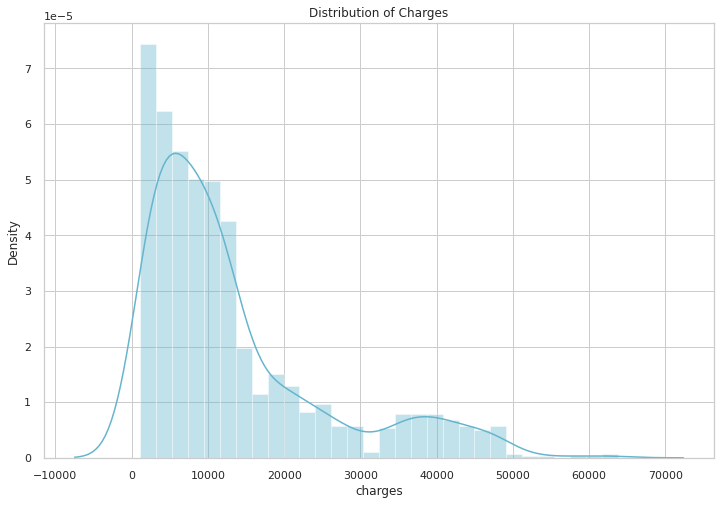

In [27]:
sn.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sn.distplot(df['charges'], kde = True, color = 'c')
plt.title('Distribution of Charges')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


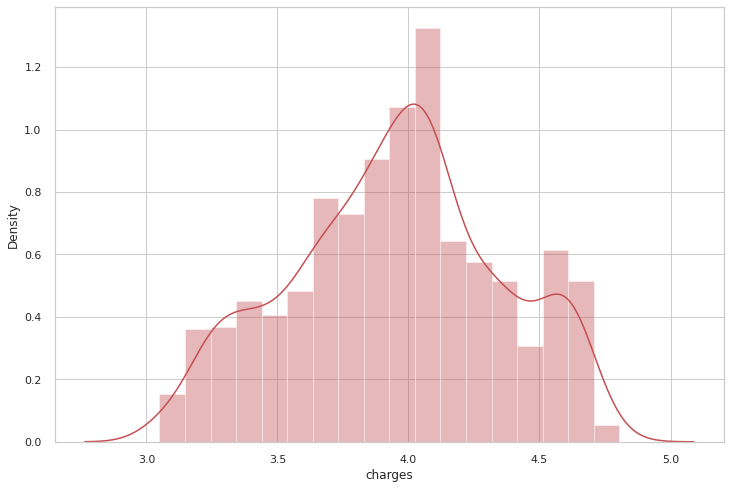

In [28]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sn.distplot(np.log10(df['charges']), kde = True, color = 'r' )

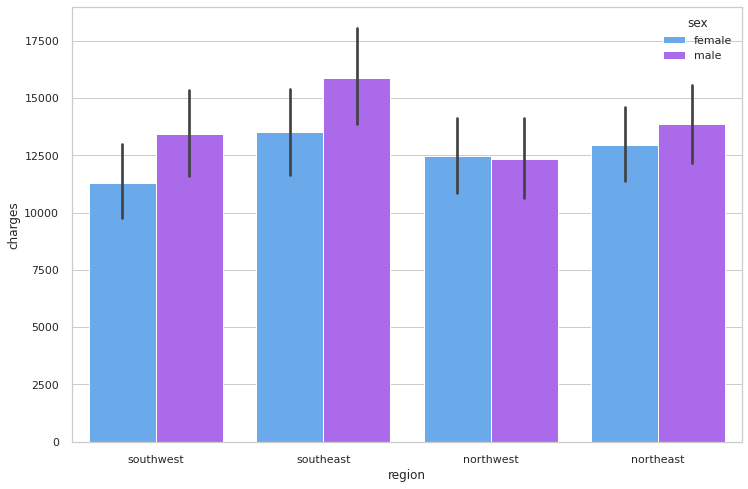

In [29]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sn.barplot(x='region', y='charges', hue='sex', data=df, palette='cool')

# **Кластеризация**

## Метод локтя

/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


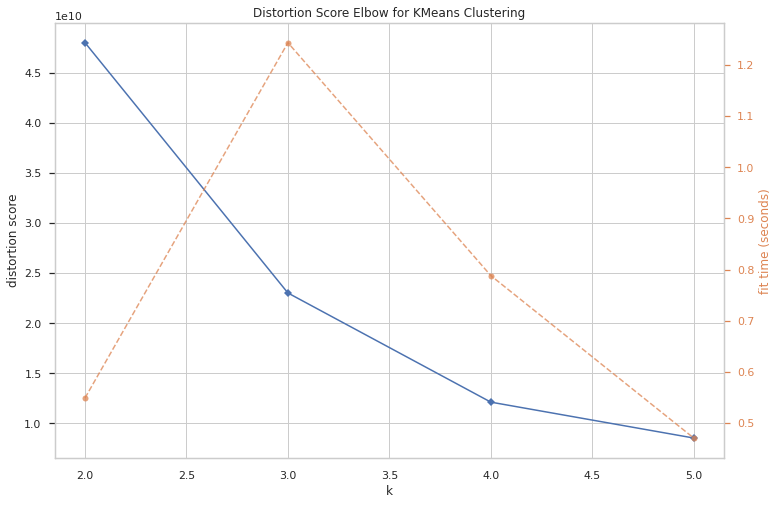

In [30]:

X = df[["bmi", "charges"]]
kmeans = KMeans(n_clusters=3)  
kmeans.fit(X)
fig = plt.figure(figsize=(12,8))


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,6))

visualizer.fit(X)
visualizer.poof() 

Оптимальное число кластеров - 3

## K-means

In [31]:
print(kmeans.cluster_centers_)

[[3.04573436e+01 5.91998783e+03]
 [3.45685503e+01 4.02796228e+04]
 [2.92734605e+01 1.72988098e+04]]


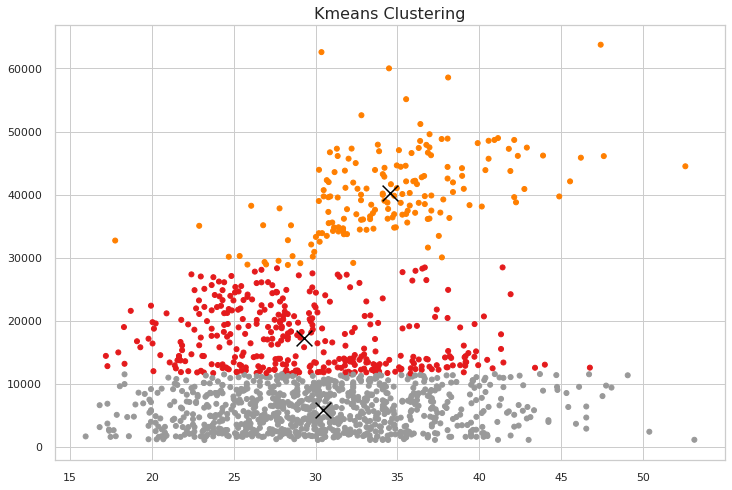

In [32]:
fig = plt.figure(figsize=(12,8))

plt.scatter(X.values[:,0], X.values[:,1], c=kmeans.labels_, cmap="Set1_r", s=25)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black', marker="x", s=250) # центры кластеров
plt.title("Kmeans Clustering", fontsize=16)
plt.show()

dbscan

In [33]:

X = df[['age','bmi']].values

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [34]:
print(labels)

[0 0 0 ... 0 0 0]


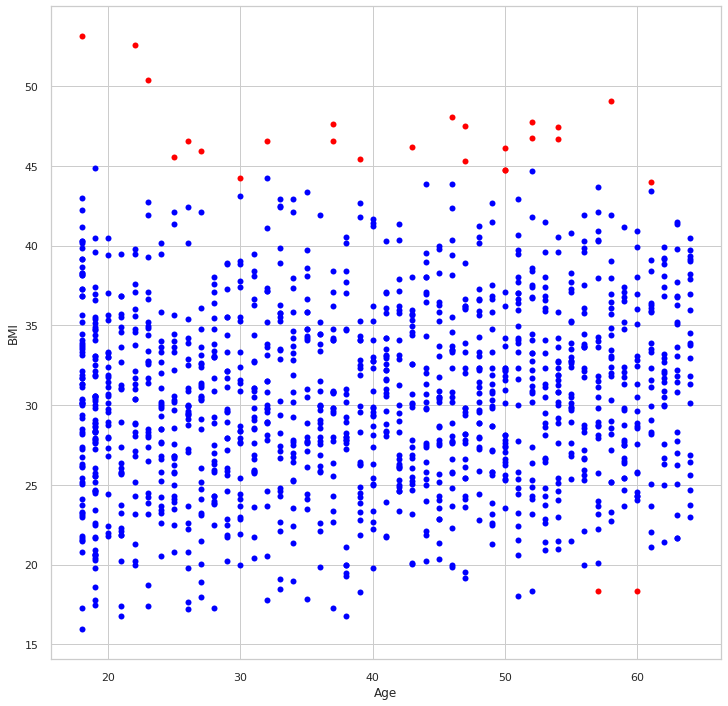

In [35]:
plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Age');
plt.ylabel('BMI');

In [36]:

fig = px.scatter_3d(df, x='age', y='bmi', z='charges',
              color='smoker')
fig.show()

One hot encoding

In [37]:
s = pd.Series(df.smoker)
axe = pd.DataFrame(pd.get_dummies(s))

In [38]:
axe

,0,1
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
1333,1,0
1334,1,0
1335,1,0
1336,1,0


In [39]:
df["yes_smoker"] =axe[1]
df["no_smoker"] = axe[0]

Добавили категориальную перемнную для курящих людей.

In [40]:
df.head()

,age,sex,bmi,children,smoker,region,charges,yes_smoker,no_smoker
0,19,female,27.900,0,1,southwest,16884.92400,1,0
1,18,male,33.770,1,0,southeast,1725.55230,0,1
2,28,male,33.000,3,0,southeast,4449.46200,0,1
3,33,male,22.705,0,0,northwest,21984.47061,0,1
4,32,male,28.880,0,0,northwest,3866.85520,0,1


Посмотрим на ещё 2 кластеризации для новых переменных в 2д и зд. Раньше мы брали расходы и имт, сейчас посмотрим возраст и курение/ используем категориальную переменную

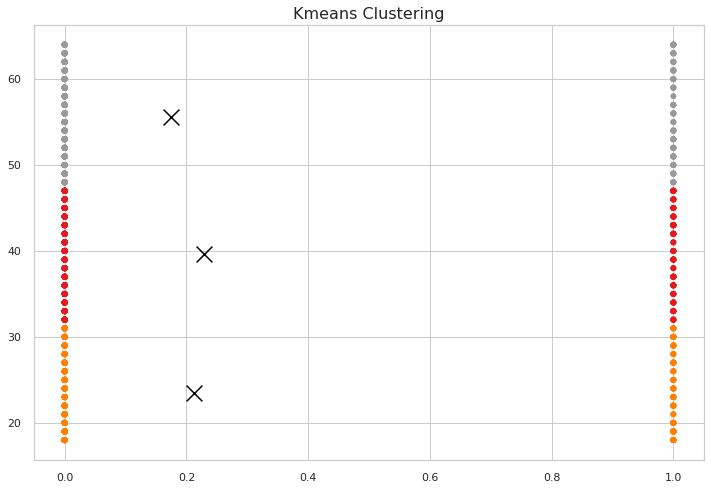

In [41]:
X = df[["yes_smoker", "age"]]
fig = plt.figure(figsize=(12,8))
kmeans = KMeans(n_clusters=3)  
kmeans.fit(X)
plt.scatter(X.values[:,0], X.values[:,1], c=kmeans.labels_, cmap="Set1_r", s=25)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black', marker="x", s=250)
plt.title("Kmeans Clustering", fontsize=16)
plt.show()

In [42]:

X = df[['yes_smoker','age']].values

db = DBSCAN(eps=3.0, min_samples=4).fit(X)
labels = db.labels_

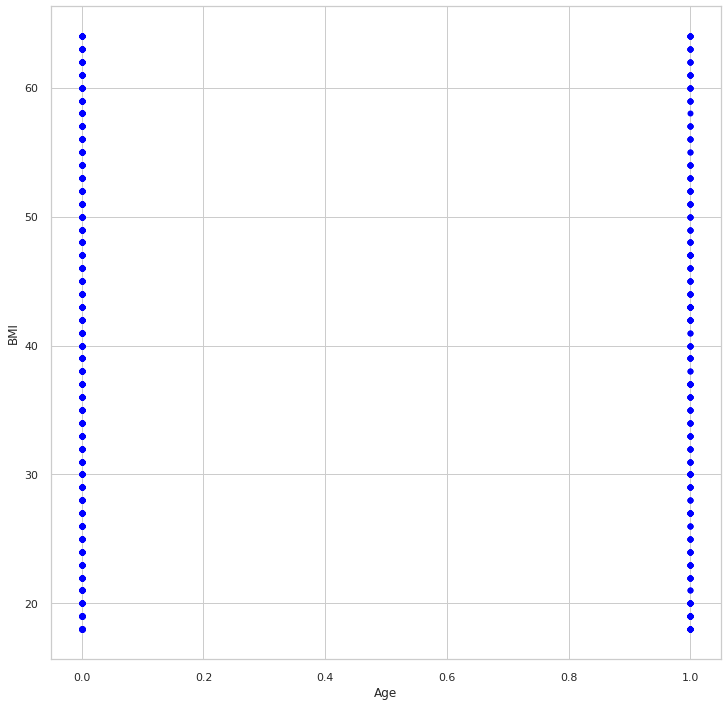

In [43]:
plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Age');
plt.ylabel('BMI');

In [44]:

fig = px.scatter_3d(df, x='yes_smoker', y='age', z='charges',
              color='smoker')
fig.show()

Немного сексизма

In [45]:
di = {"male": 1, 
      "female": 0,
     }
df["sex"].replace(di, inplace=True)
df=df.drop(columns = "region")

Иерархическая кластеризация

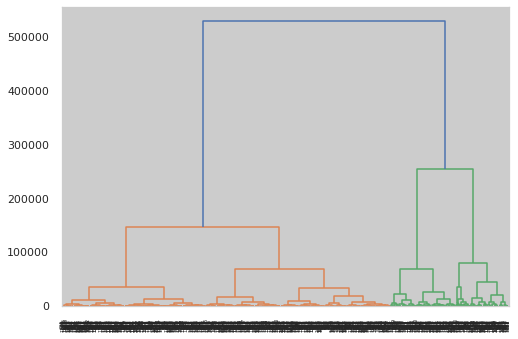

In [46]:

linkage_data = linkage(df, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

Разделим на кластеры по возрасту и тратам.

In [47]:
len(df)

1338

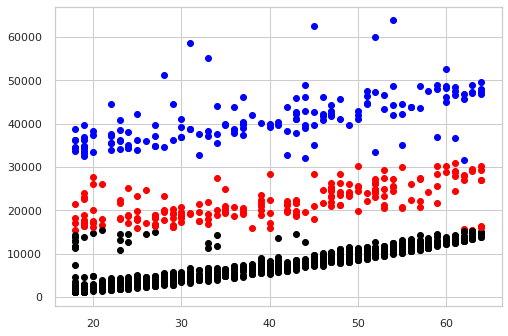

In [48]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(df)
colors=["black","blue","red"]
for i in range(len(df)):
  if labels[i]==1:
    plt.scatter(df["age"][i], df["charges"][i], c=colors[1])
  elif labels[i]==0:
    plt.scatter(df["age"][i], df["charges"][i], c=colors[0])
  else:
    plt.scatter(df["age"][i], df["charges"][i], c=colors[2])
plt.show()

# **Регрессия** 

## Регрессия с autosklearn

Задача-регрессия. Нужно построить модель для прогноза трат клиентов по их личным данным. Колонка трат- charges.

In [49]:
!pip install auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import autosklearn.regression

Мы поставили autosklearn,теперь нужно разделить данные и обучить модель.

In [52]:
X = df.drop(columns = ["charges","sex"])
y = df["charges"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1)

In [53]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=30)
automl.fit(X_train, y_train)

[WARNING] [2022-12-03 19:38:52,475:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=3, time_left_for_this_task=30)

In [54]:
y_predicted = automl.predict(X_test)
y_redicted_tr = automl.predict(X_train)

Создадим функцию для поиска основных характеристик моделей. В будущем пригодится для быстрого сравнения их показателей,которые можно прочитать ниже. Кстати, в задачах линейной регрессии,включая лес, принято считать качество модели по R2 и RMSE. Считается,что RMSE,в отличие от MSE имеет те же единицы измерения(доллары в нашем случае),что и результат, поэтому её легко интерпретировать заказчику. А R_squared это уже давний стандарт для измерения моделей всех видов регрессий.

In [55]:

def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 

    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    try:
      mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
      print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    except:
      pass    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [56]:
print("Метрики Automl")
auto=regression_results(y_test,y_predicted)


Метрики Automl
explained_variance:  0.7302
mean_squared_log_error:  0.2634
r2:  0.7297
MAE:  3954.5095
MSE:  36357799.5854
RMSE:  6029.7429


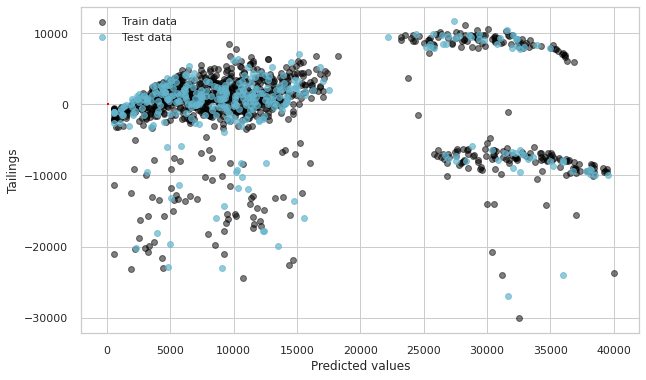

In [57]:
plt.figure(figsize=(10,6))

plt.scatter(y_redicted_tr,y_redicted_tr  - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(y_predicted,y_predicted- y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 200, lw = 2, color = 'red')
plt.show()

Впринципе,результат неплохой,попробуем его улучшить. Цель: победить r2:  0.73,RMSE:  6029.

## Построим регрессию на основе Деревьев,Леса,Градиентного бустинга

In [58]:
df = pd.read_csv('https://www.dropbox.com/s/lddn7qsu3kfvkvh/insurance.csv?dl=1', sep=',')

Применяем LabelEncoder для категориальных переменных.

In [59]:
df2=df.copy()
#sex
le = LabelEncoder()
le.fit(df2.sex.drop_duplicates()) 
df2.sex = le.transform(df2.sex)
# smoker
le.fit(df2.smoker.drop_duplicates()) 
df2.smoker = le.transform(df2.smoker)
#region
le.fit(df2.region.drop_duplicates()) 
df2.region = le.transform(df2.region)

In [60]:

X =df2.drop(columns="charges")
Y=df2["charges"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [61]:
#Обучим классификаторы, используя разобранные в  занятие алгоритмы

#Дерево решений
model_tree = tree.DecisionTreeRegressor( random_state=42,max_depth=2).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestRegressor(n_estimators=100, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))


In [62]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

Посмотрим на важность признаков(самая главная-Курит человек или нет,отрыв от других огромный, сразу понятно что курить не только вредно, но и дорого)

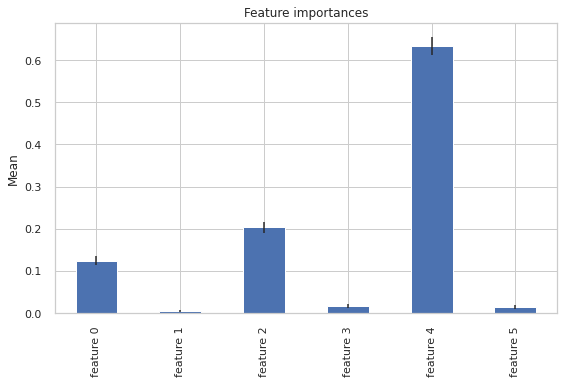

In [63]:

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean")
fig.tight_layout()

In [64]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict(X_train)
Y_rf_train_proba=model_rf.predict(X_train)
Y_gb_train_proba=model_gb.predict(X_train)



#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)


#вероятности
Y_tree_tst_proba=model_tree.predict(X_test)
Y_rf_tst_proba=model_rf.predict(X_test)
Y_gb_tst_proba=model_gb.predict(X_test)


In [65]:

print("Метрики Деревья решений на тестовой выборке")
TREE_CLR=regression_results(y_test,Y_tree_tst)
print("-----------------------------")
print("Метрики Случайный лес на тестовой выборке")
RF_CLR=regression_results(y_test,Y_rf_tst)
print("-----------------------------")
print("Метрики Градиентный бустинг на тестовой выборке")
GB_CLR=regression_results(y_test,Y_gb_tst)
print("-----------------------------")




Метрики Деревья решений на тестовой выборке
explained_variance:  0.8058
mean_squared_log_error:  0.3182
r2:  0.8055
MAE:  3378.808
MSE:  26162166.5812
RMSE:  5114.8965
-----------------------------
Метрики Случайный лес на тестовой выборке
explained_variance:  0.8342
mean_squared_log_error:  0.1901
r2:  0.8322
MAE:  2641.7987
MSE:  22568245.7852
RMSE:  4750.6048
-----------------------------
Метрики Градиентный бустинг на тестовой выборке
explained_variance:  0.7102
r2:  0.71
MAE:  4296.7658
MSE:  39015686.657
RMSE:  6246.2538
-----------------------------


Построим скаттер-плот

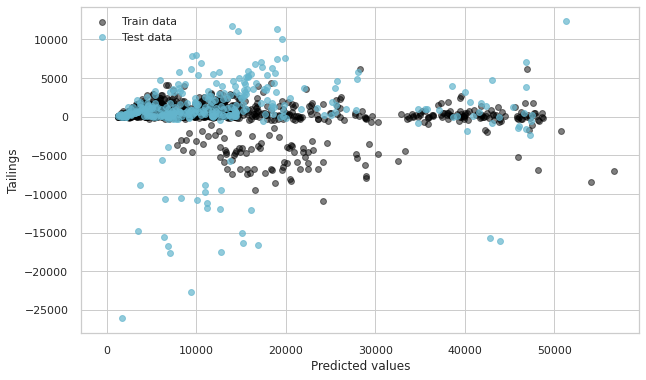

In [66]:
plt.figure(figsize=(10,6))

plt.scatter(Y_rf_train,Y_rf_train - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(Y_rf_tst,Y_rf_tst- y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 20, lw = 2, color = 'red')
plt.show()

Лучший-случайный лес. У него оценки: r2:  0.8322,RMSE:  4750.6048. Вприципе,этого уже достаточно чтобы с чистой совестью подать резюме в полиматику, но попробуем получить больше

## Добавим полимониальный коэффициент

Если раньше мы ограничивались линйеными функциями для построения регрессии,то теперь будем использовать полиномиальный коэфициент для charges. Его смысл заключается в том,что для каждого charges он добавляет массив из признаков,возведенных во все степени ниже degree/ это должно помочь повысить точность модели.

In [67]:
X = df2.drop(['charges'], axis = 1)
Y = df2.charges

quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad,Y, random_state = 1)

In [68]:
X_train[0]

array([  1.  ,  28.  ,   0.  ,  25.8 ,   0.  ,   0.  ,   3.  , 784.  ,
         0.  , 722.4 ,   0.  ,   0.  ,  84.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  , 665.64,   0.  ,   0.  ,  77.4 ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   9.  ])

In [69]:
forest = RandomForestRegressor(n_estimators = 100,
                              random_state = 1,
                              n_jobs = -1)
forest.fit(X_train,Y_train)
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)


In [70]:
regression_results(Y_test,forest_test_pred)

explained_variance:  0.842
mean_squared_log_error:  0.1977
r2:  0.8403
MAE:  2579.3598
MSE:  21477416.5568
RMSE:  4634.3734


Построим скаттер-плот

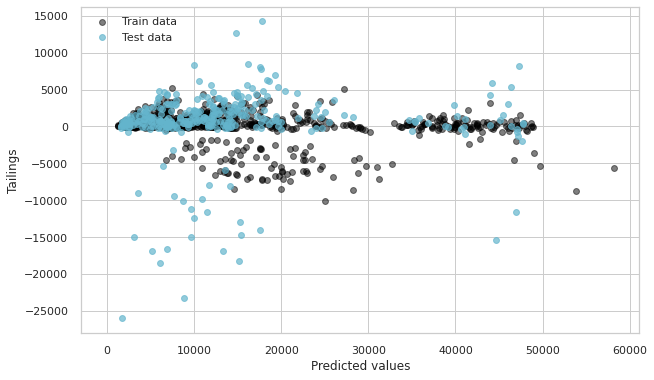

In [71]:
plt.figure(figsize=(10,6))

plt.scatter(forest_train_pred,forest_train_pred - Y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(forest_test_pred,forest_test_pred - Y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 20, lw = 2, color = 'red')
plt.show()

Что имеем: повышенную r2,пониженную RMSE. Всё хорошо,даже по графику разюрос меньше(нужно приглядеться)

## Нормализация через Minmaxscaler

In [72]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [73]:
# создаём трансформер столбцов

ct = make_column_transformer((MinMaxScaler(), ['age', 'bmi', 'children']), 
                             (OneHotEncoder(handle_unknown = 'ignore'), ['sex', 'smoker', 'region']))

In [74]:
X = df.drop('charges', axis = 1)
y = df['charges']

In [75]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [76]:
# Фитим трейнинговую выборку
ct.fit(X_train)

# Трансформим нормализованную выборку с OneHotEncoding
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

In [77]:
#Обучим классификаторы, используя разобранные в  занятие алгоритмы

#Дерево решений
model_tree = tree.DecisionTreeRegressor( random_state=42,max_depth=2).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestRegressor(n_estimators=100, 
                                  random_state=42,  bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))


In [78]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict(X_train)
Y_rf_train_proba=model_rf.predict(X_train)
Y_gb_train_proba=model_gb.predict(X_train)



#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)


#вероятности
Y_tree_tst_proba=model_tree.predict(X_test)
Y_rf_tst_proba=model_rf.predict(X_test)
Y_gb_tst_proba=model_gb.predict(X_test)


Построим скаттер-плот

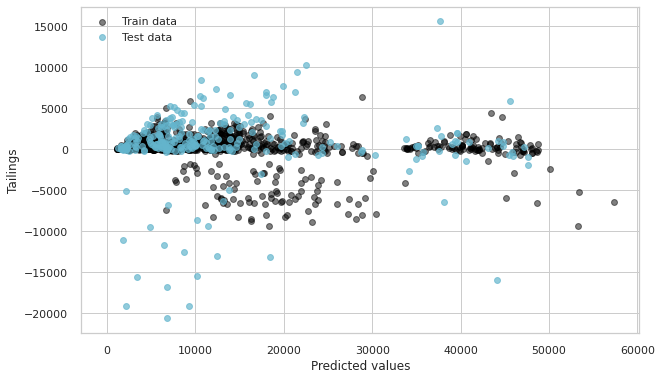

In [79]:
plt.figure(figsize=(10,6))

plt.scatter(Y_rf_train,Y_rf_train - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(Y_rf_tst,Y_rf_tst- y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 20, lw = 2, color = 'red')
plt.show()

In [80]:

print("Метрики Деревья решений на тестовой выборке")
TREE_CLR=regression_results(y_test,Y_tree_tst)
print("-----------------------------")
print("Метрики Случайный лес на тестовой выборке")
RF_CLR=regression_results(y_test,Y_rf_tst)
print("-----------------------------")
print("Метрики Градиентный бустинг на тестовой выборке")
GB_CLR=regression_results(y_test,Y_gb_tst)
print("-----------------------------")




Метрики Деревья решений на тестовой выборке
explained_variance:  0.8365
mean_squared_log_error:  0.3187
r2:  0.8355
MAE:  3406.5853
MSE:  24727794.7186
RMSE:  4972.705
-----------------------------
Метрики Случайный лес на тестовой выборке
explained_variance:  0.871
mean_squared_log_error:  0.2192
r2:  0.8688
MAE:  2551.4218
MSE:  19728634.7029
RMSE:  4441.6928
-----------------------------
Метрики Градиентный бустинг на тестовой выборке
explained_variance:  0.7519
mean_squared_log_error:  0.4087
r2:  0.7511
MAE:  4534.9824
MSE:  37419011.318
RMSE:  6117.1081
-----------------------------


Ого,мы смогли увеличить наш r2 коэфициент и сильно понизить RMSE

## Последний способ нормализовать ненормальные данные через boxcox

Я пробовал использовть основную формулу бокса кокса,но результаты были так себе. Поэтому решением является просто залогорифмировать таргетный столбец и посмотреть что получится мяу

In [81]:
#применим OneHotEncoding
categorical_columns = ['sex','children', 'smoker', 'region']
df_encode = pd.get_dummies(data = df, prefix = 'OHE', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
              dtype='int64')

In [82]:
df_encode

,age,bmi,charges,OHE_male,OHE_1,OHE_2,OHE_3,OHE_4,OHE_5,OHE_yes,OHE_northwest,OHE_southeast,OHE_southwest
0,19,27.900,16884.92400,0,0,0,0,0,0,1,0,0,1
1,18,33.770,1725.55230,1,1,0,0,0,0,0,0,1,0
2,28,33.000,4449.46200,1,0,0,1,0,0,0,0,1,0
3,33,22.705,21984.47061,1,0,0,0,0,0,0,1,0,0
4,32,28.880,3866.85520,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,10600.54830,1,0,0,1,0,0,0,1,0,0
1334,18,31.920,2205.98080,0,0,0,0,0,0,0,0,0,0
1335,18,36.850,1629.83350,0,0,0,0,0,0,0,0,1,0
1336,21,25.800,2007.94500,0,0,0,0,0,0,0,0,0,1


In [83]:
df_encode['charges'] = np.log(df_encode['charges'])

In [84]:
df_encode['charges'] 

0        9.734176
1        7.453302
2        8.400538
3        9.998092
4        8.260197
          ...    
1333     9.268661
1334     7.698927
1335     7.396233
1336     7.604867
1337    10.279914
Name: charges, Length: 1338, dtype: float64

In [85]:

X = df_encode.drop('charges',axis=1)
y = df_encode['charges']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [86]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [87]:
y_pred_sk = lin_reg.predict(X_test)
y_pred_tr = lin_reg.predict(X_train)

regression_results(y_test,y_pred_sk)

explained_variance:  0.7897
mean_squared_log_error:  0.0017
r2:  0.7887
MAE:  0.2803
MSE:  0.1778
RMSE:  0.4216


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



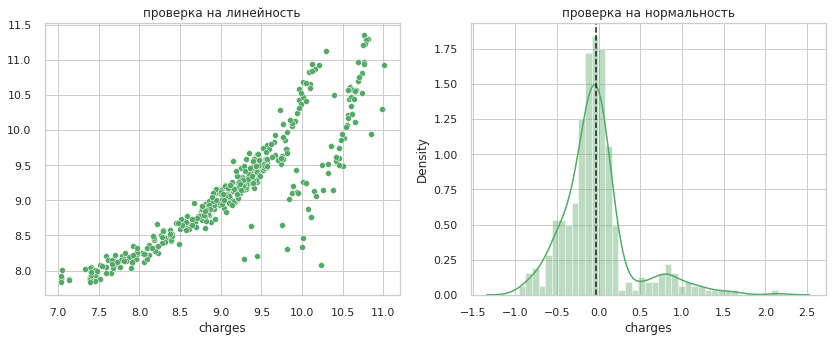

In [88]:

f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sn.scatterplot(y_test,y_pred_sk,ax=ax,color='g')
ax.set_title('проверка на линейность')

ax = f.add_subplot(122)
sn.distplot((y_test - y_pred_sk),ax=ax,color='g')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('проверка на нормальность');

Распределение похоже на нормальное.

Построим скаттер-плот

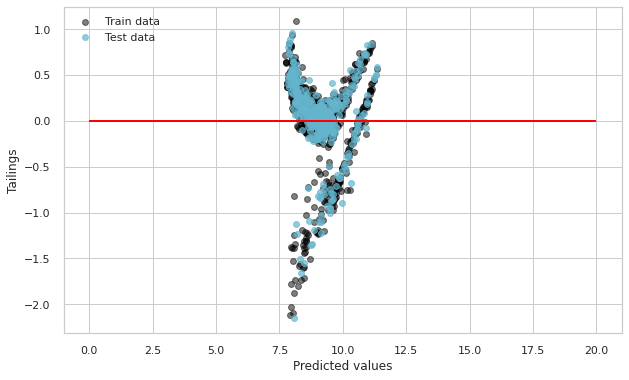

In [89]:
plt.figure(figsize=(10,6))

plt.scatter(y_pred_tr,y_pred_tr - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(y_pred_sk,y_pred_sk - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 20, lw = 2, color = 'red')
plt.show()

Мы провели независимое тестирование и пришли к таким выводам:


1. Лучший результат показал случайный лес с применением полиномиального коэффициента.
2. Наша модель лучше чем autosklearn на:
R2:0.14
RMSE:1578
3. Лучшие графики получаются при нормализации данных.
